In [4]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np
import numpy as np
import scipy.optimize

def biasFunc(x, m, c):
    '''Systematic bias of shear estimation
    Parameters:
    ----
    x:  input shear
    m:  multiplicative bias
    c:  additive bias

    Returns:
    ----
    y:  estimated shear
    '''
    y   =   (1+m) * x + c
    return y

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        #data['s2n'] = res['s2n']
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

In [13]:
def make_data(rng, FbyB, shear, version=0, SbyN=20):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    FbyB: float
        source by background ratio
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear,
        g2=0,
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    r_aper = 10
    
    ngrid = im.array.shape[0]
    flux_tmp = np.sum((im.array)[ngrid//2-r_aper:ngrid//2+r_aper+1, ngrid//2-r_aper:ngrid//2+r_aper+1])
    F = SbyN**2.*(1+FbyB)/FbyB
    B = F/FbyB
    B_val = B/(2.*r_aper+1)**2.
    F_val=F/(2.*r_aper+1)**2.
        
    im = (im/flux_tmp)*F
    
    if version==0:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        # do not rescale with std_tmp here, since std_tmp is the std of the *total* original noise on aperture region
        # here, B_val is the target noise on single pixel level
        # the original noise's std on pixel level is 1!!
        noise_image *= np.sqrt(B_val + im.array)
        
        if False:
            # if we assume we know accurately the variance map
            variance_array = B_val+im.array 
        else:
            # if we assume we can only accurately measure 
            # the average variance in the aperture
            variance_array = np.ones_like(im.array)*(B_val+F_val)
    if version==1:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val+F_val)
        variance_array = np.ones_like(im.array)*(B_val+F_val)
        
    im += noise_image
    # noise variance map
    wt = 1.0/variance_array

        
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

def test_make_data():
    '''
    unit test for make_data function
    '''
    r_aper    = 10 # 1/2 of the width of the aperture (was fixed to 2)
    FBratioArr= np.logspace(start=-2, stop=2, num=5, base=10.0)
    num_tests = len(FBratioArr)
    g_true= [0]
    for version in range(2):
        rng = np.random.RandomState(1024)
        print('Testing for version %d' %version)
        for FbyB in FBratioArr:
            print('    Testing for F/B=%.2f' %FbyB)
            for gin in g_true:
                obs = make_data(rng=rng, FbyB=FbyB, shear=gin, version=version, SbyN=10.)
                img = obs.image
                ngrid=img.shape[0]
                varImg=(1./obs.weight)
                varSum= np.sum(varImg[ngrid//2-r_aper:ngrid//2+r_aper+1, ngrid//2-r_aper:ngrid//2+r_aper+1])
                flux  =np.sum(img[ngrid//2-r_aper:ngrid//2+r_aper+1, ngrid//2-r_aper:ngrid//2+r_aper+1])
                noi_std=np.sqrt(varSum)
                print('        Measrued Aperture SNR=%.2f' %(flux/noi_std))
                
                resdict, obsdict = boot.go(obs)
                dlist=[]
                for stype, sres in resdict.items():
                    st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                    dlist.append(st)
                    del st
                del obs,resdict,obsdict
            
                _dat=np.hstack(dlist)
                del dlist # delete variable not to be used again
        
                w = select(data=_dat, shear_type='noshear')
                print('        Measured ngmix SNR =%.2f' %(_dat['s2n'][w].mean()))
                del _dat
    return

In [14]:
test_make_data()

Testing for version 0
    Testing for F/B=0.01
        Measrued Aperture SNR=10.04
        Measured ngmix SNR =17.66
    Testing for F/B=0.10
        Measrued Aperture SNR=9.85
        Measured ngmix SNR =14.95
    Testing for F/B=1.00
        Measrued Aperture SNR=8.90
        Measured ngmix SNR =18.57
    Testing for F/B=10.00
        Measrued Aperture SNR=9.04
        Measured ngmix SNR =14.80
    Testing for F/B=100.00
        Measrued Aperture SNR=10.22
        Measured ngmix SNR =15.48
Testing for version 1
    Testing for F/B=0.01
        Measrued Aperture SNR=10.03
        Measured ngmix SNR =17.28
    Testing for F/B=0.10
        Measrued Aperture SNR=10.01
        Measured ngmix SNR =17.31
    Testing for F/B=1.00
        Measrued Aperture SNR=8.78
        Measured ngmix SNR =16.42
    Testing for F/B=10.00
        Measrued Aperture SNR=8.92
        Measured ngmix SNR =17.93
    Testing for F/B=100.00
        Measrued Aperture SNR=9.88
        Measured ngmix SNR =15.96


In [15]:
def analyze(rng, num_gals, FbyB, shear_true, version=0, first=False, SbyN=20):
    if ~version:
        print('Analysising for F/B= %.2f' %FbyB)
    else:
        print('Analysising for F/B= 0')
    x = []
    y = []
    shear_error = []
    
    for i in range(len(shear_true)):
        shearIn=shear_true[i]
        print('    Analysising for shear= %.2f' %shearIn)
        dlist = []
        
        for j in range(num_gals):
            obs = make_data(rng=rng, FbyB=FbyB, shear=shearIn, version=version, SbyN=20)

            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                del st
            del obs,resdict,obsdict
            
        _dat=np.hstack(dlist)
        del dlist # delete variable not to be used again
        
        w = select(data=_dat, shear_type='noshear')
        w_1p = select(data=_dat, shear_type='1p')
        w_1m = select(data=_dat, shear_type='1m')
        g_1p = _dat['g'][w_1p, 0].mean()
        g_1m = _dat['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02

        g = _dat['g'][w].mean(axis=0)
        shear = g / R11

        g_error = _dat['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)

        x.append(FbyB) # avoid calling any global variable
        y.append(shear[0])
        del _dat  # in order to save space, avoid storing each _dat in to a data list and I 
                  # delet the _dat after measurement
            
    return (x, y, shear_error)

In [16]:
FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_tests = len(FBratioArr)
num_gals = 100
g_true= [-0.03, -0.01, 0, 0.01, 0.03]

shear_measurementsSB = []
shear_errorsSB = []

shear_measurementsB = []
shear_errorsB = []

for n in range(num_tests):
    analysis_BandS = analyze(rng, num_gals, FBratioArr[n], g_true, version=0, first = True, SbyN=20)
    
    shear_measurementsSB.append(analysis_BandS[1])
    shear_errorsSB.append(analysis_BandS[2])
    
    analysis_Bonly = analyze(rng, num_gals, FBratioArr[n], g_true, version=1, first = True, SbyN=20)
    
    shear_measurementsB.append(analysis_Bonly[1])
    shear_errorsB.append(analysis_Bonly[2])


Analysising for F/B= 0.01
    Analysising for shear= -0.03
    Analysising for shear= -0.01
    Analysising for shear= 0.00
    Analysising for shear= 0.01
    Analysising for shear= 0.03
Analysising for F/B= 0.01
    Analysising for shear= -0.03
    Analysising for shear= -0.01
    Analysising for shear= 0.00
    Analysising for shear= 0.01
    Analysising for shear= 0.03
Analysising for F/B= 0.10
    Analysising for shear= -0.03
    Analysising for shear= -0.01
    Analysising for shear= 0.00
    Analysising for shear= 0.01
    Analysising for shear= 0.03
Analysising for F/B= 0.10
    Analysising for shear= -0.03
    Analysising for shear= -0.01
    Analysising for shear= 0.00
    Analysising for shear= 0.01
    Analysising for shear= 0.03
Analysising for F/B= 1.00
    Analysising for shear= -0.03
    Analysising for shear= -0.01
    Analysising for shear= 0.00
    Analysising for shear= 0.01
    Analysising for shear= 0.03
Analysising for F/B= 1.00
    Analysising for shear= -0.03
 

In [17]:
print(shear_measurementsSB, "\n")
print(shear_errorsSB, "\n")
print(shear_measurementsB, "\n")
print(shear_errorsB)

[[-0.026262117046248902, -0.0023302773479897875, 0.0001778955415647492, 0.008083199876094418, 0.0366713086386647], [-0.027593251944891668, -0.019778283394931227, 0.006561443169992456, 0.014684377606664844, 0.034468566363238896], [-0.026891063379116422, -0.009182367503994664, -0.0011496210989333621, 0.013530139998621283, 0.04909599400299969], [-0.024907137259526188, -0.0069794308661623216, -0.013629279338526373, 0.010877383210691205, 0.02065610845655566], [-0.03378030521684918, -0.000891664380771613, 0.034486959132205355, 0.00860115769172915, 0.03716225404160734]] 

[[0.010260211915984802, 0.009384817422724602, 0.009052580158642607, 0.009811395809175626, 0.008448776081182175], [0.0115308472688149, 0.010380022341675614, 0.00905567792857826, 0.011370522176654399, 0.00895535622568705], [0.011828572759500859, 0.01167738010399907, 0.012553453294078873, 0.013564628445587828, 0.012124429453383882], [0.013819093499366584, 0.016519358322990157, 0.013280619574060166, 0.015420853042608982, 0.01593

In [18]:
#popt, pcov = scipy.optimize.curve_fit(biasFunc, shear_true[0], shear[0], sigma = shear_error[0])

x = np.linspace(-.03*1.5, .03*1.5, len(FBratioArr))

biasListSB = []
errorListSB = []
biasListB = []
errorListB = []

for i in range(len(g_true)):
    print(shear_measurementsSB[i], "\n")
    
print("shape =", np.shape(g_true[0]))

for n in range(len(g_true)):    

    print("g_true[n] =", g_true[n])
    poptSB, pcovSB = scipy.optimize.curve_fit(biasFunc, g_true, shear_measurementsSB[n], sigma = shear_errorsSB[n])
    print("shear_measurementsSB[n] = ",shear_measurementsSB[n], "\n")
    print("shear_errorsSB[n] = ",shear_errorsSB[n], "\n")
    print("poptSB = ",poptSB)
    print("pcovSB =", pcovSB, "\n")
    poptB, pcovB = scipy.optimize.curve_fit(biasFunc, g_true, shear_measurementsB[n], sigma = shear_errorsB[n])
    print("shear_measurementsB[n] = ",shear_measurementsB[n], "\n")
    print("shear_errorsB[n] = ",shear_errorsB[n], "\n")
    print("poptB = ",poptB)
    print("pcovB =", pcovB, "\n", "\n")
    
    biasListSB.append(poptSB)
    biasListB.append(poptB)
    
    errorListSB.append(pcovSB)
    errorListB.append(pcovB)
    
    del poptSB, pcovSB, poptB, pcovB


print("biasListSB =", biasListSB, "\n")
print("errorListSB =", errorListSB, "\n")
print("biasListB =", biasListB, "\n")
print("errorListB =", errorListB)

[-0.026262117046248902, -0.0023302773479897875, 0.0001778955415647492, 0.008083199876094418, 0.0366713086386647] 

[-0.027593251944891668, -0.019778283394931227, 0.006561443169992456, 0.014684377606664844, 0.034468566363238896] 

[-0.026891063379116422, -0.009182367503994664, -0.0011496210989333621, 0.013530139998621283, 0.04909599400299969] 

[-0.024907137259526188, -0.0069794308661623216, -0.013629279338526373, 0.010877383210691205, 0.02065610845655566] 

[-0.03378030521684918, -0.000891664380771613, 0.034486959132205355, 0.00860115769172915, 0.03716225404160734] 

shape = ()
g_true[n] = -0.03
shear_measurementsSB[n] =  [-0.026262117046248902, -0.0023302773479897875, 0.0001778955415647492, 0.008083199876094418, 0.0366713086386647] 

shear_errorsSB[n] =  [0.010260211915984802, 0.009384817422724602, 0.009052580158642607, 0.009811395809175626, 0.008448776081182175] 

poptSB =  [0.01019093 0.00342934]
pcovSB = [[ 1.12155410e-02 -2.45264318e-05]
 [-2.45264318e-05  4.55462240e-06]] 

shear

In [19]:
mListSB=[]
cListSB=[]
mListB=[]
cListB=[]
mErrSB=[]
cErrSB=[]
mErrB=[]
cErrB=[]

for n in range(len(biasListSB)):
    mListSB.append(biasListSB[n][0])
    mListB.append(biasListB[n][0])
    cListSB.append(biasListSB[n][1])
    cListB.append(biasListB[n][1])
    mErrSB.append(np.sqrt(np.diag(errorListSB[n])[0]))
    cErrSB.append(np.sqrt(np.diag(errorListSB[n])[1]))
    mErrB.append(np.sqrt(np.diag(errorListB[n])[0]))
    cErrB.append(np.sqrt(np.diag(errorListB[n])[1]))
    

[array([0.01019093, 0.00342934]), array([0.11017162, 0.00172073]), array([0.2544724 , 0.00536757]), array([-0.23181701, -0.00354064]), array([0.14416369, 0.00785159])]
[array([-0.11532404,  0.00585254]), array([-0.14271923,  0.00340075]), array([0.17455531, 0.00399052]), array([ 0.02632308, -0.00543503]), array([-9.47566846e-02,  1.55666751e-05])]


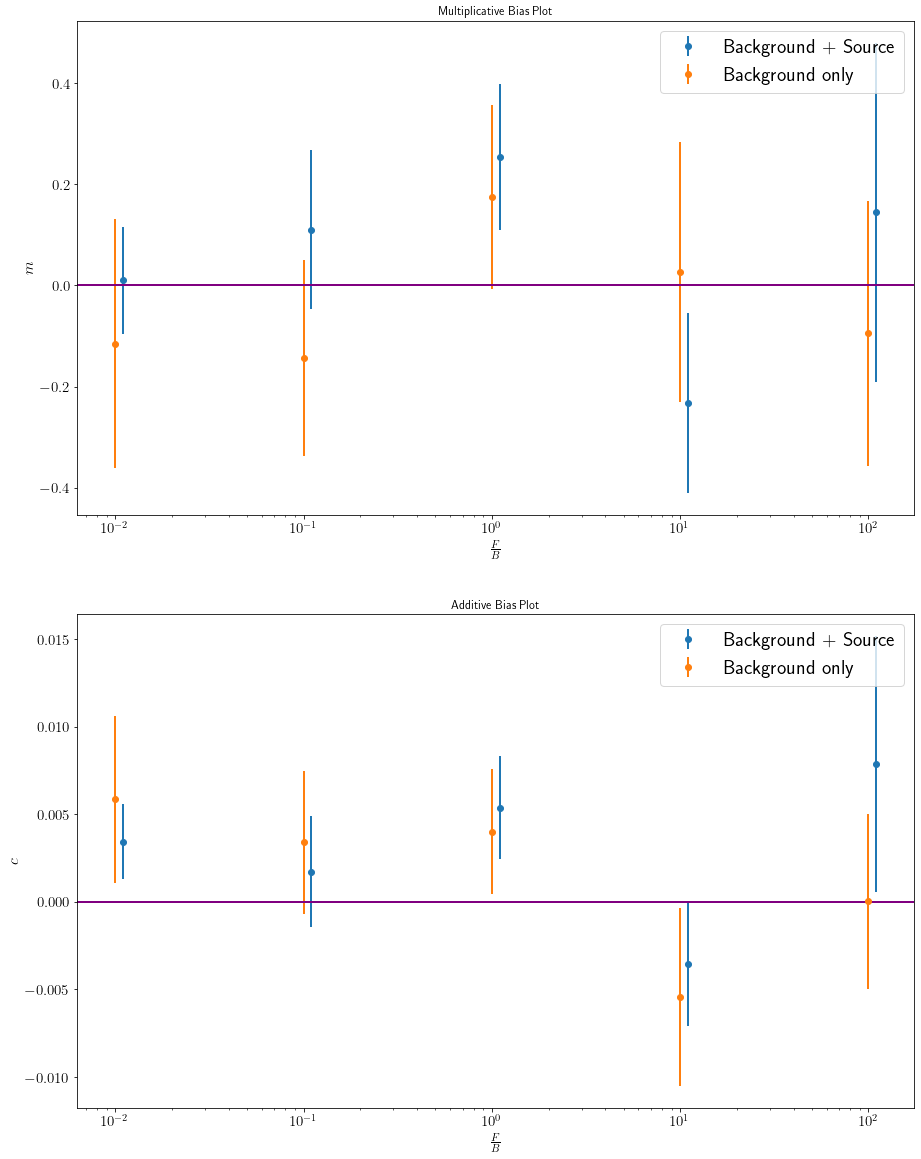

In [20]:
%matplotlib inline
plt.close()
fig, (p1, p2) = plt.subplots(2, figsize=(15,20))

print(biasListSB)
print(biasListB)

plot1 = p1.errorbar(np.array(FBratioArr)*1.1, mListSB, mErrSB, fmt='o', label='Background + Source')
p1.errorbar(FBratioArr, mListB, mErrB, fmt='o', label='Background only')
p1.set_title("Multiplicative Bias Plot")
p1.axhline(0, color="purple")
p1.set_xlabel(r'$\frac{F}{B}$', fontsize=16)
p1.set_ylabel(r'$m$', fontsize=16)
p1.set_xscale("log")
p1.legend()

plot2 = p2.errorbar(np.array(FBratioArr)*1.1, cListSB, cErrSB, fmt='o', label='Background + Source')
p2.errorbar(FBratioArr, cListB, cErrB, fmt = 'o', label ='Background only')
p2.axhline(0, color="purple")
p2.set_xlabel(r'$\frac{F}{B}$', fontsize=16)
p2.set_ylabel(r'$c$', fontsize=16)
p2.set_xscale("log")
p2.set_title("Additive Bias Plot")
p2.legend()

plt.show()